## Now we move onto coding the ML model itself

First we make a manifest of cleaned frames, this helps keep everything organised in one place and makes the whole process easier as we dont need to continuously scan our folders every time. Below I scan the `frames_3fps_clean` folder (ie `FRAME_OUT_DIR`) and collect the image paths and agent names into a dataframe called `manifest_df`.

In [15]:
from pathlib import Path
import pandas as pd
from torchvision import transforms
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import models

PROJECT_DIR = Path(r"D:\Valorant ML data")
FRAME_OUT_DIR = PROJECT_DIR / "frames_3fps_clean"

print("Using frames from:", FRAME_OUT_DIR)

Using frames from: D:\Valorant ML data\frames_3fps_clean


In [16]:
rows = []

#we loop over folders in FRAME_OUT_DIR
for agent_folder in sorted(FRAME_OUT_DIR.iterdir()):
    agent = agent_folder.name
    for img_path in sorted(agent_folder.glob("*.jpg")):
        rows.append({"filepath": str(img_path), "agent": agent})
manifest_df = pd.DataFrame(rows)



print("total images:", len(manifest_df))
print("\nper-agent counts:")
print(manifest_df["agent"].value_counts().sort_index())   #alphabetically sorted for consistency

manifest_df.head()

total images: 4671

per-agent counts:
agent
Astra        185
Breach       241
Brimstone    305
Chamber      347
Cipher       337
Clove        324
Deadlock     299
Fade         321
Gekko        345
Iso          356
Jett         215
Kayo         359
Neon         335
Raze         341
Sage         361
Name: count, dtype: int64


,filepath,agent
0,D:\Valorant ML data\frames_3fps_clean\Astra\Va...,Astra
1,D:\Valorant ML data\frames_3fps_clean\Astra\Va...,Astra
2,D:\Valorant ML data\frames_3fps_clean\Astra\Va...,Astra
3,D:\Valorant ML data\frames_3fps_clean\Astra\Va...,Astra
4,D:\Valorant ML data\frames_3fps_clean\Astra\Va...,Astra


#### Train, Val, Test Split
Now we need to create a split for the data for the training, validation and test groups. I just arbitrarily chose a simple 70/15/15 split. I also use stratification so that each agent is included in all the groups. 

In [17]:
from sklearn.model_selection import train_test_split
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

In [18]:
# 70% train and 30% temp
train_df, temp_df = train_test_split(manifest_df, test_size=0.30, stratify=manifest_df['agent'], random_state=42)

# split the remaining temp 30% into 15% val, 15% test (still stratified)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['agent'], random_state=42)

print("split sizes:  ", "train:", len(train_df), "| val:", len(val_df), "| test:", len(test_df))

# quick look at class balance in the train split
print("\ntrain counts:")
print(train_df['agent'].value_counts().sort_index())

split sizes:   train: 3269 | val: 701 | test: 701

train counts:
agent
Astra        130
Breach       169
Brimstone    213
Chamber      243
Cipher       236
Clove        227
Deadlock     209
Fade         225
Gekko        241
Iso          249
Jett         150
Kayo         251
Neon         234
Raze         239
Sage         253
Name: count, dtype: int64


#### Summary Stats on Data
There is quite a bit of variance here (I admit my data collection was not the best). Out of interest, I calculate summary stats of interest:

In [19]:
train_counts = train_df['agent'].value_counts().sort_index()

mean_count = train_counts.mean()
var_count  = train_counts.var()  

print("Mean:", round(mean_count, 2))
print("Variance:", round(var_count, 2))
print("Standard Deviation:", round(var_count**0.5, 2))

Mean: 217.93
Variance: 1461.07
Standard Deviation: 38.22


#### Torchvision Transforms
We now set up basic torchvision transforms:

Note that `IMG_SIZE` denotes the fact that resnet only takes images that are 224x224 pixels

In [20]:
# plain list of classes in a fixed order
class_names = sorted(train_df['agent'].unique())
num_classes = len(class_names)

print("classes:", class_names)
print("num_classes:", num_classes)

# we then define variables for image transforms 
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),                                #random flips help with training
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),])

eval_tfms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),])

classes: ['Astra', 'Breach', 'Brimstone', 'Chamber', 'Cipher', 'Clove', 'Deadlock', 'Fade', 'Gekko', 'Iso', 'Jett', 'Kayo', 'Neon', 'Raze', 'Sage']
num_classes: 15


#### Dataloaders
This cell defines `FrameTableDataset`, a minimal PyTorch Dataset that adapts our DataFrame (with columns: `'filepath'`, `'agent'`) into `(image_tensor, label_int)` samples. It's a class and we subclass `torch.utils.data.Dataset` and implement the required protocol:
- `__len__` returns number of samples and `__getitem__(idx)`  returns the idx-th sample.
- `__getitem__` reads the image from folder, converts BGR to RGB, wraps as PIL, applies the given transforms (either `train_tfms` or `eval_tfms`), and maps the string label to an integer using the ordered class_names list (ie list of agents).

We then create train/val/test dataset instances with the right transforms, and put them in DataLoaders:
* `train_loader` shuffles but val/test dont
* `batch_size` controls batch size
* `num_workers=0` is standard practice online
* `pin_memory` can speed up host to GPU copies when using cuda





In [21]:
#This helps us adapt our manifest table into something Pytorch can batch
class FrameTableDataset(Dataset):
    def __init__(self, table, class_names, transform=None):
        self.table = table.reset_index(drop=True) #this makes the indexing clean
        self.class_names = list(class_names)
        self.transform = transform

    def __len__(self):
        return len(self.table)  #this returns no. of rows in the table

    def __getitem__(self, idx):
        row = self.table.iloc[idx]   #takes the row at idx
        path = row['filepath']       #finds the filepath
        label_name = row['agent']    
        # map label name (agent name) to integer
        label = self.class_names.index(label_name)
        img_bgr = cv2.imread(path) 
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img_rgb)      #wraps the image as a PIL image
        if self.transform is not None:
            x = self.transform(pil_img)
        else:
            x = torch.from_numpy(np.transpose(img_rgb, (2, 0, 1))).float() / 255.0
        return x, int(label)

# datasets
train_ds = FrameTableDataset(train_df, class_names, transform=train_tfms)
val_ds = FrameTableDataset(val_df, class_names, transform=eval_tfms)
test_ds = FrameTableDataset(test_df, class_names, transform=eval_tfms)


#Dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)  #Only shuffle the training data loader.
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

print("sizes:", "train:", len(train_ds), "| val:", len(val_ds), "| test:", len(test_ds))

sizes: train: 3269 | val: 701 | test: 701


#### Training Device and Model Selection
Here I choose my device. Because I have an RTX 3060 Ti I obviously want to use cuda to speed up the training process. I also load the pretrained resnet18, however I need to adjust the final output layer to the number of agents (15).

In [22]:
DEVICE = torch.device("cuda")
num_classes = len(class_names)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes) #this adjust the final layer

# move to device, which is 3060 ti in my case
model = model.to(DEVICE)
print("device:", DEVICE)

device: cuda


WE will run gradient descent with Adam. cross-entropy loss matches multi-class classification by maxxing the log likelihood of the correct class. We print average loss (how wrong on average) and accuracy each epoch. Online its recommended to use a small learning rate specifically when tuning a pre trained net.
On the forward pass we `model(x)` calculateds raw class scores, `criterion(logits, y)` calculates the cross-entropy loss. Then on the backprop `loss.backward()` computes gradients, and `optimiser.step()` uses ADAM to update the weights.. 

After training I went back to also save important values, which will be used for grapnhing later (I wish I did this before I trained, so I wouldnt have to wait for model to re-train).

In [23]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 5

In [24]:
def train_one_epoch(model, loader, optimiser, device):
    model.train()   #this puts the layers in training mode
    #we set all this counters to 0 at first
    total_loss = 0.0
    total_correct = 0
    total_seen = 0  
    for x, y in loader:  #here x=images and y=labels
        x = x.to(device)
        y = y.to(device)  #offloads data to 3060 Ti for training
  
        optimiser.zero_grad()  #clears old gradients to prevent them building up across batches
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimiser.step()

        total_loss += loss.item() * x.size(0)     #we add this batchs loss to the running total, we multiply by batch size
        preds = logits.argmax(dim=1)       #the predicted class=index with the largest score per sample
        total_correct += (preds == y).sum().item()    #this counts how many predictions match the true labels (y) in this batch
        total_seen += x.size(0)     #this is just a counter of batches.

    avg_loss = total_loss / max(1, total_seen)    #need the max functon here or else could divide by 0
    acc = total_correct / max(1, total_seen)
    return avg_loss, acc

In [25]:
@torch.no_grad() #disables gradient tracking for everything inside the function for lower memory and faster evaluation

#this fucntion evaluates on a loader(which is the val set here)
def eval_one_loader(model, loader, device):
    model.eval()   #eval mode
    total_loss = 0.0
    total_correct = 0
    total_seen = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)     # forward pass only and no grads calculated
        loss = criterion(logits, y)       #we need to keep track of loss here as we use val loss to spot overfitting

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_seen += x.size(0)

    avg_loss = total_loss / max(1, total_seen)
    acc = total_correct / max(1, total_seen)
    return avg_loss, acc

### Training Loop
Includes counters for accuracy and loss values. I also save each epoch to then track the best validation score so I can save the best weights for the model.

In [26]:
epoch_list = [] 
train_loss_hist = [] 
val_loss_hist = []  
train_acc_hist = [] 
val_acc_hist = []  

best_va_acc = -1.0  #Initialise this at a -ve value so that the first epoch will obviously have higher accuracy, and hence register
best_epoch = None
best_state = None  # copy of the best model weights

for epoch in range(1, EPOCHS + 1):   #1-indexxed for nicer printing
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimiser, DEVICE)   #Calculate traning loss and accuracy
    va_loss, va_acc = eval_one_loader(model, val_loader, DEVICE)                #Calcualte validation loss and accuracy

    # I check for new best validation accuracy
    is_best = va_acc > best_va_acc
    if is_best:
        best_va_acc = va_acc
        best_epoch = epoch
        # store a CPU copy of the current best weights (so it can be saved later). state_dict() maps each layer to its parameter tensor
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        
    print(f"epoch {epoch} - train loss {tr_loss:.4f}  acc {tr_acc:.4f} --- val loss {va_loss:.4f}  acc {va_acc:.4f}")
    
    epoch_list.append(epoch)          
    train_loss_hist.append(tr_loss)  
    val_loss_hist.append(va_loss)     
    train_acc_hist.append(tr_acc)  
    val_acc_hist.append(va_acc)

epoch 1 - train loss 1.3731  acc 0.6185 --- val loss 0.4242  acc 0.8716
epoch 2 - train loss 0.2077  acc 0.9590 --- val loss 0.1974  acc 0.9529
epoch 3 - train loss 0.0705  acc 0.9887 --- val loss 0.1136  acc 0.9672
epoch 4 - train loss 0.0562  acc 0.9887 --- val loss 0.1116  acc 0.9658
epoch 5 - train loss 0.0342  acc 0.9939 --- val loss 0.0799  acc 0.9829


#### Running Model on Test Data
Next we run the model on the test set with gradients off, then uses `argmax` as the predicted class. Under cross-entropy, argmax matches the class with the highest estimated probability. The per class table helps spot any issues with specific class.

In [34]:
model.eval()  #as we are doing inference

# Load best weights if available
model.load_state_dict(best_state)
print(f"Loaded best val weights from epoch {best_epoch} (val_acc={best_va_acc:.4f})")

all_preds = []
all_labels = []
with torch.no_grad():   #again using no_grad in this loop
    for x, y in test_loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        scores = model(x)         # raw class scores
        preds = scores.argmax(1)          # pick class with highest score

        #We then move these tensors into the cpu, as we cannot convert them to arrays on the GPU
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
#we convert these to numpy arrays 
all_preds = np.array(all_preds)
all_labels = np.array(all_labels) 

# overall accuracy
test_acc = float((all_preds == all_labels).mean())  #we average over everyhting, float(...==...) effectively defines an indicator function
print(f"test accuracy: {test_acc:.4f}")

#We first calculate counts of correct and total per agent
counts = {name: {"correct": 0, "total": 0} for name in class_names}
for true_lab, pred_lab in zip(all_labels, all_preds):   #iterates over tuples we need
    name = class_names[int(true_lab)]
    counts[name]["total"] += 1
    if pred_lab == true_lab: 
        counts[name]["correct"] += 1  #only if our prediction is correct we up the correct counter

#Per agent accuracy
rows = []
for name in sorted(counts.keys()):
    cor = counts[name]["correct"]
    tot = counts[name]["total"]
    acc = (cor / tot) if tot > 0 else float("nan")  #to again prevent division by 0
    rows.append({"class": name, "correct": cor, "total": tot, "accuracy": acc})

per_class_df = pd.DataFrame(rows)
print("\nper class accuracy:")
print(per_class_df.to_string(index=False))

Loaded best val weights from epoch 5 (val_acc=0.9829)
test accuracy: 0.9800

per class accuracy:
    class  correct  total  accuracy
    Astra       28     28  1.000000
   Breach       36     36  1.000000
Brimstone       46     46  1.000000
  Chamber       51     52  0.980769
   Cipher       49     50  0.980000
    Clove       48     48  1.000000
 Deadlock       44     45  0.977778
     Fade       46     48  0.958333
    Gekko       51     52  0.980769
      Iso       52     54  0.962963
     Jett       29     32  0.906250
     Kayo       53     54  0.981481
     Neon       50     51  0.980392
     Raze       51     51  1.000000
     Sage       53     54  0.981481


#### Saving the Model
Okay so the heavy lifting is done, we can now do things like save our model weights to the stated file.

In [35]:
WEIGHTS_PATH = Path("weights/resnet18_best.pt")
WEIGHTS_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(best_state, WEIGHTS_PATH)

#### Visualisation
Using matplotlib, we plot 2 graphs, one for loss and one for accuracy:

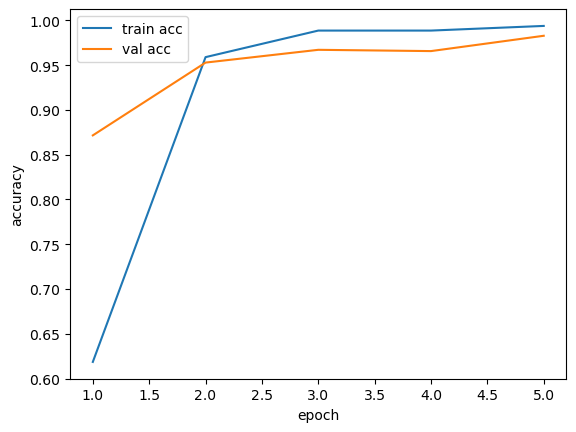

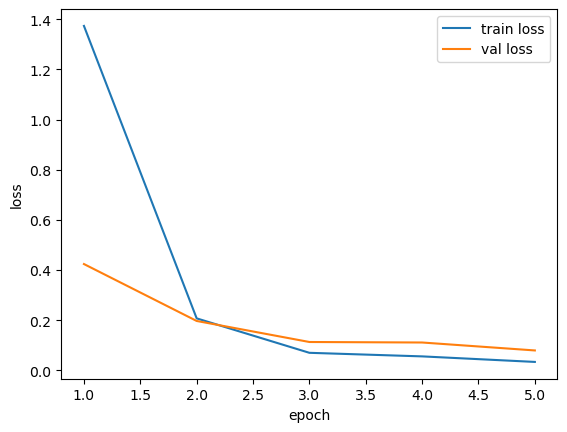

In [36]:
#this is our plot for accuracy
plt.figure()
plt.plot(epoch_list, train_acc_hist, label="train acc")
plt.plot(epoch_list, val_acc_hist, label="val acc")
plt.xlabel("epoch"); 
plt.ylabel("accuracy"); 
plt.legend(); 
plt.show()

#this is our plot for loss
plt.figure()
plt.plot(epoch_list, train_loss_hist, label="train loss")
plt.plot(epoch_list, val_loss_hist, label="val loss")
plt.xlabel("epoch"); 
plt.ylabel("loss"); 
plt.legend(); 
plt.show()

#### Test Image
Lastly, I took some extra images of a couple agents on a different map (Bind) and tested the model.


In [37]:
def predict(image_path):
    model.eval()  #again we are in inference mode
    img = Image.open(image_path).convert("RGB")
    x = eval_tfms(img).unsqueeze(0).to(DEVICE)  #the shape is  1 x C x H x W
    with torch.no_grad():
        scores = model(x)    # computes class scores
        pred_idx = int(scores.argmax(1).item()) # highest score will obviously be predicted class
        prob = float(F.softmax(scores, dim=1)[0, pred_idx].item())
    plt.imshow(img)
    plt.title(f"{class_names[pred_idx]}  (p={prob:.5f})")   #displays probability to 5 decimal places
    plt.axis("off")
    plt.show()  #I edited to add this last part to just show the image. This helps me understand why or why not the model failed

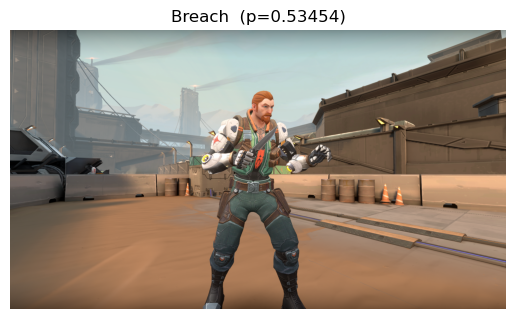

In [38]:
predict(r"D:\Valorant ML data\Screenshot (12).png")